### Stocks Trading 

In [29]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [3]:
#define the ticker symbol
tickerSymbol = 'PLTR'

In [6]:
tickerData = yf.Ticker(tickerSymbol)

In [8]:
#get the historical prices for this ticker
tickerDf = tickerData.history(interval='1d', start='2024-1-1', end='2024-11-13')

In [10]:
priceData = tickerDf.Open

In [11]:
priceData = priceData.asfreq(pd.infer_freq(priceData.index))

In [16]:
priceData.index[-1].year+1

2025

Text(0.5, 1.0, 'PLTR Price Data')

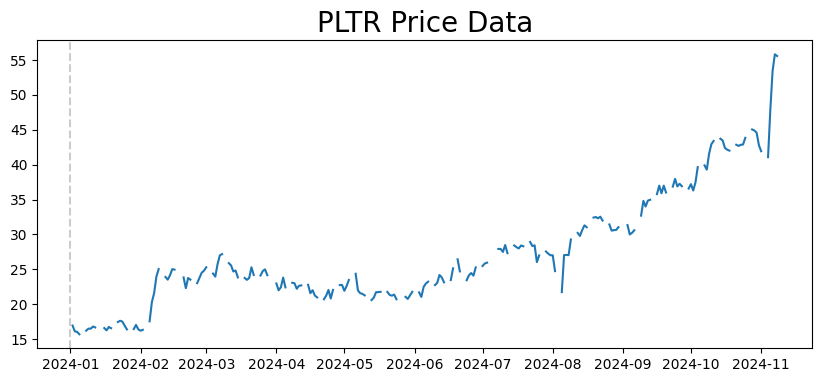

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(priceData)
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%tickerSymbol, fontsize=20)

#### Basic Buying Protocol:
- Buy if stock increasing for $b$ consecutive days
#### Basic Selling Protocols:
- Sell if stock decreasing for $s$ consecutive days (and we've made a profit)

In [94]:
import pytz
def buying_condition(sub_series):
        return (sub_series > 0).all()
def selling_condition(sub_series):
        return (sub_series < 0).all()

start_date = datetime(2024, 11, 1, 0, 0, 0)  # Starting date without timezone

# Generate date range
date_range = pd.date_range(start=start_date, periods=7, freq='D')

# Set the time zone to UTC-5 (Eastern Standard Time)
timezone = pytz.timezone('US/Eastern')
date_range_with_tz = date_range.tz_localize(timezone)

# Create series with the formatted date range
series = pd.Series(data=[0.5, -0.4, 0.2, 0.3, 0.5, -0.44, -0.9], index=date_range_with_tz)
series

2024-11-01 00:00:00-04:00    0.50
2024-11-02 00:00:00-04:00   -0.40
2024-11-03 00:00:00-04:00    0.20
2024-11-04 00:00:00-05:00    0.30
2024-11-05 00:00:00-05:00    0.50
2024-11-06 00:00:00-05:00   -0.44
2024-11-07 00:00:00-05:00   -0.90
dtype: float64

In [67]:
series.rolling(2).apply(selling_condition)

2024-11-01    NaN
2024-11-02    0.0
2024-11-03    0.0
2024-11-04    0.0
2024-11-05    0.0
2024-11-06    0.0
2024-11-07    1.0
Freq: D, dtype: float64

In [64]:
def get_buying_selling_days(price_data, b, s):
    
    #get the percent change day after day: d_t-d_{t-1}/d_t
    # pct_change = price_data.pct_change()[1:] #[1:] because the results will only begin from day 2
    
    #this function checks the buying condition
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    
    #this function checks the selling condition
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    
    """
    1. series.rolling(2) creates a rolling window of size 2, meaning each subset of data (window) will contain two consecutive values.
    2. .apply(buying_condition) then applies the buying_condition function to each of these rolling windows.
    3. If both values in the 2-day window are positive, buying_condition returns True, which is represented as 1.
    """
    
    #get all buying days in the data
    buying_days = price_data.rolling(b).apply(buying_condition)
    
    #get all potential selling days in the data
    potential_selling_days = price_data.rolling(s).apply(selling_condition)
    
    #return a dictionary
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}

In [95]:
get_buying_selling_days(series, 2, 2)

{'buying_days': 2024-11-01 00:00:00-04:00    NaN
 2024-11-02 00:00:00-04:00    0.0
 2024-11-03 00:00:00-04:00    0.0
 2024-11-04 00:00:00-05:00    1.0
 2024-11-05 00:00:00-05:00    1.0
 2024-11-06 00:00:00-05:00    0.0
 2024-11-07 00:00:00-05:00    0.0
 dtype: float64,
 'potential_selling_days': 2024-11-01 00:00:00-04:00    NaN
 2024-11-02 00:00:00-04:00    0.0
 2024-11-03 00:00:00-04:00    0.0
 2024-11-04 00:00:00-05:00    0.0
 2024-11-05 00:00:00-05:00    0.0
 2024-11-06 00:00:00-05:00    0.0
 2024-11-07 00:00:00-05:00    1.0
 dtype: float64}

In [ ]:
info_dict = get_buying_selling_days(series,  2, 2)
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

# Create a DataFrame to store information
df_stocks = pd.DataFrame(index=buying_days.index)
df_stocks['buying_day'] = (buying_days == 1)
df_stocks['potential_selling_day'] = (potential_selling_days == 1)
df_stocks['price'] = priceData

# Only keep days that are either buying or potential selling days
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]


,buying_day,potential_selling_day,price
2024-11-01 00:00:00-04:00,False,False,41.930000
2024-11-02 00:00:00-04:00,False,False,NaN
2024-11-03 00:00:00-04:00,False,False,NaN
2024-11-04 00:00:00-05:00,True,False,41.080002
2024-11-05 00:00:00-05:00,True,False,47.860001
2024-11-06 00:00:00-05:00,False,False,53.439999
2024-11-07 00:00:00-05:00,False,True,55.820000


In [98]:
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]
df_stocks

,buying_day,potential_selling_day,price
2024-11-04 00:00:00-05:00,True,False,41.080002
2024-11-05 00:00:00-05:00,True,False,47.860001
2024-11-07 00:00:00-05:00,False,True,55.820000


In [101]:
for date, data in df_stocks.iterrows():
    print(date)
    if data.buying_day:
        print(data.price)

2024-11-04 00:00:00-05:00
41.08000183105469
2024-11-05 00:00:00-05:00
47.86000061035156
2024-11-07 00:00:00-05:00


In [ ]:
series[datetime(2024, 11, 4): datetime(2024, 11, 7)]
"""
d1 = up 30% , d2 = up another 50%, d3 = down 44%, d4 = down 90%
"""

2024-11-04    0.30
2024-11-05    0.50
2024-11-06   -0.44
2024-11-07   -0.90
Freq: D, dtype: float64

In [ ]:
"""
Say buy_date = 11-04 and potential_sell_date = 11-07, however 11-04's value represents the pct_change from 11-03 to 11-04.
We are only intending to buy from 11-04 onwards so we have to take the pct_change of 11-04 to 11-05 which is the 11-05's value.
Hence we will need to offset the series to not include the buy_date 11-04.
1 + series[..] is so that each day represents the factor of growth, 
i.e. d1 = up 30% so factor = asset_value*1.30, d4 = down 90% so factor = asset_value*0.10
"""
sub_series = 1+ series[datetime(2024, 11, 4) + timedelta(hours=1): datetime(2024, 11, 7)]
sub_series


2024-11-05    1.50
2024-11-06    0.56
2024-11-07    0.10
Freq: D, dtype: float64

In [ ]:
"""
Returns the total cumulative growth = 1.5 * 0.56 * 0.1 which means if our asset 
increases by 50% on d2, 
decrease by 44% in d3 and 
on the last day decrease by 90%, the overall growth factor will be 0.084 i.e. 84$ left if invested 1000$
"""
sub_series.product()
# Returns the total cumulative growth = 1.5 * 0.56 * 0.1 which means if our asset increases by 50% on d2, decrease by 44% in d3 and on the last day decrease by 90%, the overall growth will be 0.1092

0.08399999999999999

In [ ]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    """
    This helper function will check if the cumulative percent change
    between a buying and potential selling day yields overall growth
    """
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1): potential_sell_date]

    return sub_series.product() > 1 #Only consider selling if

In [ ]:
def get_investing_result(df_stocks, starting_funds, verbose=True):
    
    #get a copy of price data
    price_data = df_stocks.price
    
    #at start, not holding any shares
    holding = False
    
    #init vars
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #init dict of buying and selling dates
    events_list = []
    
    #for each buying day and potential selling day...
    for date, data in df_stocks.iterrows():
        
        #if not currently holding shares, and this is a buying day...
        if (not holding) and data.buying_day:
            
            #calculate the number of shares we can afford
            num_shares_to_buy = int(current_funds / data.price)
            
            #update number of shares
            current_shares += num_shares_to_buy
            
            #decrease current funds
            current_funds -= num_shares_to_buy * data.price
            
            #set last buy date
            last_buy_date = date
            events_list.append(('b', date))
            
            #we are now holding shares
            holding = True
            
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
        
        #if you are holding shares, and this is a potential selling day...
        elif holding and data.potential_selling_day:
            
            #check to make sure we're making a profit
            if check_cumulative_percent_change(price_data, last_buy_date, date):
                #add to our current funds if we are making profit
                current_funds += current_shares * data.price
                
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
                    print('--------------------------------------')
                    
                #reset current shares
                current_shares = 0
                
                #we are no longer holding shares
                holding = False
                
                events_list.append(('s', date))
                
    #get the stock price at the end of the time span
    final_stock_price = price_data[-1]
        
    #Open position: Buy without a subsequent Sell, get the final total value of all assets (funds + stock value)
    final_value = current_funds + final_stock_price * current_shares # final_stock_price * current_shares = open stock position's value
    """
    final_value includes current_funds because say there is a buy without a subsequent sell, 
    eventhough during buy, we will buy the max possible num of shares but current_fund will be depleted fully, 
    hence we need to include the leftover funds which isnt enough to purchase 1 additional share.
    """
    
    #return the percent change in value
    return round((final_value - starting_funds) / starting_funds,2), events_list

In [48]:
from itertools import product

# Initialize variables to store the best results
best_percent_change = -float('inf')
best_params = (None, None)
best_events_list = []

# Loop over all combinations of b and s from 1 to 5
for b, s in product(range(1, 6), repeat=2):
    # Get the buying and potential selling days for the current (b, s) pair
    info_dict = get_buying_selling_days(priceData, b, s)
    buying_days = info_dict['buying_days']
    potential_selling_days = info_dict['potential_selling_days']
    
    # Create a DataFrame to store information
    df_stocks = pd.DataFrame(index=buying_days.index)
    df_stocks['buying_day'] = (buying_days == 1)
    df_stocks['potential_selling_day'] = (potential_selling_days == 1)
    df_stocks['price'] = priceData
    
    # Only keep days that are either buying or potential selling days
    df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]
    
    # Evaluate the investing result for the current (b, s) pair
    percent_change, events_list = get_investing_result(df_stocks, starting_funds=10000)
    
    # Check if this result is the best one so far
    if percent_change > best_percent_change:
        best_percent_change = percent_change
        best_params = (b, s)
        best_events_list = events_list

# Print the best result
print(f"The best percent change is: {best_percent_change}")
print(f"Best parameters (b, s): {best_params}")
print("Events list:", best_events_list)

The best percent change is: 2.44
Best parameters (b, s): (1, 5)
Events list: [('b', Timestamp('2024-01-08 00:00:00-0500', tz='America/New_York'))]


In [24]:
print(percent_change)

1.82


In [64]:
info_dict = get_buying_selling_days(priceData, 1, 5)
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

# Create a DataFrame to store information
df_stocks = pd.DataFrame(index=buying_days.index)
df_stocks['buying_day'] = (buying_days == 1)
df_stocks['potential_selling_day'] = (potential_selling_days == 1)
df_stocks['price'] = priceData

# Only keep days that are either buying or potential selling days
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]

# Evaluate the investing result for the current (b, s) pair
percent_change, events_list = get_investing_result(df_stocks, starting_funds=10000)

Bought 616 shares at $16.219999313354492 on 2024-01-08 totaling $9991.52


In [63]:
percent_change, events_list = get_investing_result(df_stocks, starting_funds=10000)

Bought 616 shares at $16.219999313354492 on 2024-01-08 totaling $9991.52
Sold 616 shares at $16.399999618530273 on 2024-01-26 totaling $10102.4
--------------------------------------
Bought 614 shares at $16.450000762939453 on 2024-01-29 totaling $10100.3
Sold 614 shares at $24.700000762939453 on 2024-03-13 totaling $15165.8
--------------------------------------
Bought 611 shares at $24.829999923706055 on 2024-03-14 totaling $15171.13
Sold 611 shares at $42.150001525878906 on 2024-10-17 totaling $25753.65
--------------------------------------
Bought 601 shares at $42.86000061035156 on 2024-10-21 totaling $25758.86


In [58]:
print(percent_change)

2.35


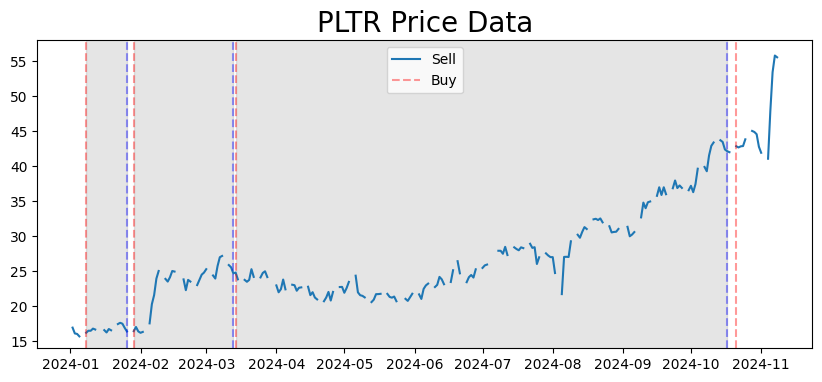

In [59]:
plt.figure(figsize=(10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.title("%s Price Data"%tickerSymbol, fontsize=20)
plt.ylim(*y_lims)
plt.legend(['Sell', 'Buy'])